In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import time
import pickle

from concurrent.futures import ProcessPoolExecutor, as_completed, ThreadPoolExecutor


import discretize 
from simpeg import maps
from simpeg.electromagnetics import time_domain as tdem

from simpeg.utils.solver_utils import get_default_solver

from simpeg.meta import MultiprocessingMetaSimulation #DaskMetaSimulation

In [2]:
Solver = get_default_solver()
Solver

pymatsolver.direct.pardiso.Pardiso

# set up models and mesh

In [88]:
rho_back = 500
sigma_back = 1./rho_back 

rho_target_conductive = 1
rho_target_resistive = 500

sigma_target_conductive = 1./rho_target_conductive
sigma_target_resistive = 1./rho_target_resistive

sigma_air = 1e-8

rx_times = np.logspace(np.log10(2e-5), np.log10(2e-3), 20)


In [89]:
def diffusion_distance(sigma, t):
    return 1260*np.sqrt(t/sigma)

In [90]:
diffusion_distance(sigma_back, 8e-3)

np.float64(2520.0)

In [91]:
tx_height = np.r_[30]

rx_x = (np.linspace(-300, 300, 31))
rx_y = rx_x[1::2]
rx_z = np.r_[0]
rx_locs = discretize.utils.ndgrid([rx_x, rx_y, rx_z])
# rx_x

In [92]:
rx_x

array([-300., -280., -260., -240., -220., -200., -180., -160., -140.,
       -120., -100.,  -80.,  -60.,  -40.,  -20.,    0.,   20.,   40.,
         60.,   80.,  100.,  120.,  140.,  160.,  180.,  200.,  220.,
        240.,  260.,  280.,  300.])

In [93]:
def gaussian_2d(x, y, x0=0.0, y0=0.0, sigma_x=1.0, sigma_y=1.0, amplitude=1.0):
    """
    Generate a 2D Gaussian distribution.

    Parameters
    ----------
    x, y : 2D np.ndarray
        Grid of x and y coordinates (use np.meshgrid).
    x0, y0 : float
        Center of the Gaussian.
    sigma_x, sigma_y : float
        Standard deviations along x and y axes.
    amplitude : float
        Peak value of the Gaussian.

    Returns
    -------
    2D np.ndarray
        Gaussian values on the grid.
    """
    return amplitude * np.exp(
        -(((x - x0)**2) / (2 * sigma_x**2) + ((y - y0)**2) / (2 * sigma_y**2))
    )


In [94]:
topo_sig_x = 80 
topo_amplitude = 200

In [95]:
rx_x.min()

np.float64(-300.0)

In [96]:
topo_x = np.linspace(rx_x.min(), rx_x.max(), 80)
topo_xy = discretize.utils.ndgrid(topo_x, topo_x)
topo = gaussian_2d(
    topo_xy[:, 0], topo_xy[:, 1], sigma_x=topo_sig_x, sigma_y=topo_sig_x, amplitude=topo_amplitude
)
topo_square = topo.reshape(len(topo_x), len(topo_x))

(-300.0, 300.0)

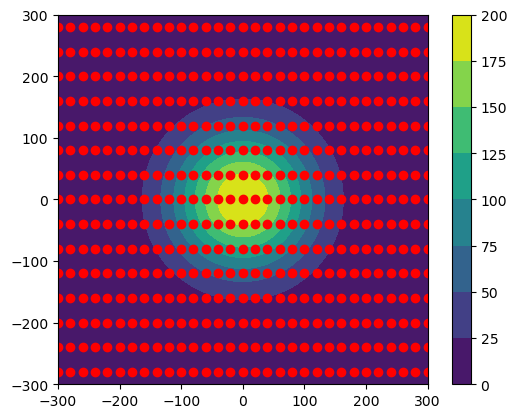

In [97]:
fig, ax = plt.subplots(1, 1)

plt.colorbar(ax.contourf(topo_x, topo_x, topo_square))
ax.plot(rx_locs[:, 0], rx_locs[:, 1], "ro")

ax.set_aspect(1)
ax.set_xlim(np.r_[-1, 1]*300)
ax.set_ylim(np.r_[-1, 1]*300)

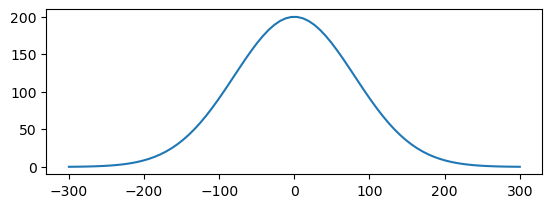

In [98]:
fig, ax = plt.subplots(1, 1)
ax.plot(topo_x, topo_square[int(len(topo_x)/2), :])
ax.set_aspect(1)

In [99]:
np.atan(150/150)*180/np.pi

np.float64(45.0)

In [100]:
flight_height = gaussian_2d(
    rx_locs[:, 0], rx_locs[:, 1], sigma_x=topo_sig_x, sigma_y=topo_sig_x, amplitude=topo_amplitude
) + tx_height
rx_locs[:, 2] = flight_height

(-300.0, 300.0)

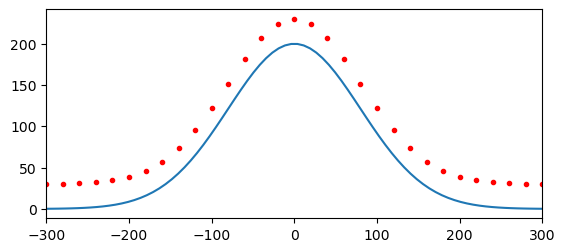

In [101]:
fig, ax = plt.subplots(1, 1)
ax.plot(topo_x, topo_square[int(len(topo_x)/2), :])

inds_rx = rx_locs[:, 1] == 0
ax.plot(rx_locs[inds_rx, 0], rx_locs[inds_rx, 2], "ro", ms=3)
ax.set_aspect(1)
ax.set_xlim(-300, 300)

In [102]:
td_octree_directory = "./td-octree-topo-halfspace"
td_octree_directory_target = "./td-octree-topo-target"
directories = [td_octree_directory, td_octree_directory_target]

In [103]:
topo_xyz = np.hstack([topo_xy, np.atleast_2d(topo).T])

for d in directories: 
    np.save(f"{d}/rx_locs.npy", rx_locs)
    np.save(f"{d}/rx_times.npy", rx_times)
    np.savetxt(f"{d}/topo.txt", topo_xyz)

In [104]:
len(topo_xyz)

6400

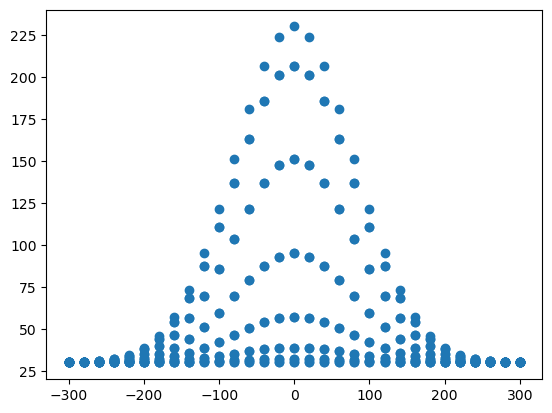

In [105]:
fig, ax = plt.subplots(1, 1)
ax.plot(rx_locs[:, 0], rx_locs[:, 2], "o")

In [106]:
source_list = []
    
for i in range(rx_locs.shape[0]): 
    rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times, orientation="z")
    src = tdem.sources.CircularLoop(
        receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10, 
        waveform=tdem.sources.StepOffWaveform()
    )
    source_list.append(src)

survey = tdem.Survey(source_list)

In [107]:

source_list = survey.source_list

for d in directories: 
    with open(f"{d}/survey.txt", "w") as f:
        f.write(f"N_TRX {len(source_list)}\n\n")
    
        for src in source_list: 
            f.write(f"TRX_LOOP\n")
            f.write(f"{src.location[0]} {src.location[1]} {src.location[2]} {src.radius} 0 0\n\n")
    
            f.write(f"N_RECV 1\n")
            f.write(f"N_TIME {len(rx_times)}\n")
            for t in rx_times:
                rx = src.receiver_list[0]
                f.write(f"{rx.locations[0, 0]} {rx.locations[0, 1]} {rx.locations[0, 2]} {t}\n")
            f.write("\n")
    
            

In [108]:
len(topo)

6400

In [109]:
working_dir = td_octree_directory_target

In [110]:
ubc_mesh = discretize.TreeMesh.read_UBC(f"{working_dir}/octree_mesh.txt")

In [111]:
ubc_mesh

OcTreeMesh,0.01% filled
Level,Number of cells
3,296
4,1512
5,1356
6,2260
7,3750
8,10424
9,31385
10,94520
Total,145503


In [112]:
topo_mesh = gaussian_2d(
    ubc_mesh.cell_centers[:, 0], ubc_mesh.cell_centers[:, 1], sigma_x=topo_sig_x, sigma_y=topo_sig_x, amplitude=topo_amplitude
)

In [113]:
halfspace_model = np.ones(ubc_mesh.n_cells)*sigma_air
halfspace_model[ubc_mesh.cell_centers[:, 2] < topo_mesh] = sigma_back

In [114]:
target_model = halfspace_model.copy()

target1_x = np.r_[-80, -20]
target1_y = np.r_[-20, 20]
target1_z = np.r_[60, 100]

target2_x = np.r_[20, 80]
target2_y = target1_y
target2_z = target1_z

inds_target1 = (
    (ubc_mesh.cell_centers[:, 0] < np.max(target1_x)) &
    (ubc_mesh.cell_centers[:, 0] > np.min(target1_x)) &
    (ubc_mesh.cell_centers[:, 1] < np.max(target1_y)) &
    (ubc_mesh.cell_centers[:, 1] > np.min(target1_y)) &
    (ubc_mesh.cell_centers[:, 2] < np.max(target1_z)) &
    (ubc_mesh.cell_centers[:, 2] > np.min(target1_z))
)

inds_target2 = (
   (ubc_mesh.cell_centers[:, 0] < np.max(target2_x)) &
   (ubc_mesh.cell_centers[:, 0] > np.min(target2_x)) &
   (ubc_mesh.cell_centers[:, 1] < np.max(target2_y)) &
   (ubc_mesh.cell_centers[:, 1] > np.min(target2_y)) &
   (ubc_mesh.cell_centers[:, 2] < np.max(target2_z)) &
   (ubc_mesh.cell_centers[:, 2] > np.min(target2_z))
)


target_model[inds_target1] = sigma_target_resistive
target_model[inds_target2] = sigma_target_conductive

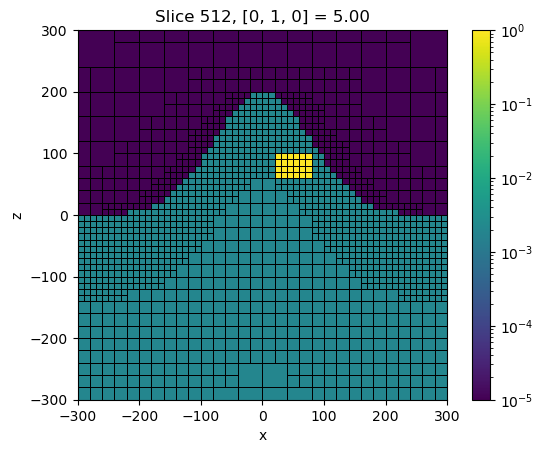

In [116]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(
    ubc_mesh.plot_slice(
        # halfspace_model, 
        target_model,
        pcolor_opts={"norm":LogNorm(vmin=1e-5, vmax=1e0)},
        grid_opts={"color":"k", "lw":0.5},
        grid=True,
        ax=ax,
        normal="Y",
    )[0], ax=ax
)
ax.set_xlim(np.r_[-1, 1]*300)
ax.set_ylim(np.r_[-1, 1]*300)
ax.set_aspect(1)

In [117]:
discretize.TreeMesh.write_model_UBC(
    ubc_mesh, f"{td_octree_directory}/halfspace.con", 
    halfspace_model
)
discretize.TreeMesh.write_model_UBC(
    ubc_mesh, f"{td_octree_directory_target}/target.con", 
    target_model
)

In [118]:
def load_pre_file(filepath, skipntx=False):
    """
    Load a GIF-style .pre file (TDoctree format).

    Parameters
    ----------
    filepath : str
        Path to the .pre-style data file

    Returns
    -------
    dict
        {
            "ignore": float or None,
            "n_trx": int,
            "transmitters": list of {
                "location": list of float,
                "n_recv": int,
                "n_time": int,
                "receivers": list of {
                    "loc": (x, y, z),
                    "time": float,
                    "data": list of float
                }
            }
        }
    """
    with open(filepath, "r") as f:
        lines = [line.strip() for line in f if line.strip()]

    i = 0
    ignore_value = None
    transmitters = []

     
    # Parse IGNORE line if present
    if lines[i].startswith("IGNORE"):
        ignore_value = float(lines[i].split()[1])
        i += 1

    if not skipntx:
        # Parse number of transmitters
        if lines[i].startswith("N_TRX"):
            n_trx = int(lines[i].split()[1])
            i += 1
        else:
            raise ValueError("Missing N_TRX line")

    while i < len(lines):
        if lines[i].startswith("TRX_LOOP"):
            i += 1
            location = list(map(float, lines[i].split()))
            i += 1
            if not lines[i].startswith("N_RECV"):
                raise ValueError("Expected N_RECV")
            n_recv = int(lines[i].split()[1])
            i += 1
            if not lines[i].startswith("N_TIME"):
                raise ValueError("Expected N_TIME")
            n_time = int(lines[i].split()[1])
            i += 1

            receivers = []
            for _ in range(n_recv * n_time):
                parts = lines[i].split()
                x, y, z = map(float, parts[0:3])
                time = float(parts[3])
                data = list(map(float, parts[4:]))
                receivers.append({
                    "loc": (x, y, z),
                    "time": time,
                    "data": data
                })
                i += 1

            transmitters.append({
                "location": location,
                "n_recv": n_recv,
                "n_time": n_time,
                "receivers": receivers
            })
        else:
            i += 1  # Skip unknown or empty lines

    return {
        "ignore": ignore_value,
        "n_trx": len(transmitters),
        "transmitters": transmitters
    }

In [119]:
len(survey.source_list)

465

In [120]:
n_times_invert = 20


In [121]:
# dpred = load_pre_file(f"{td_octree_directory}/dpred0.txt", skipntx=True)
dpred_target = load_pre_file(f"{td_octree_directory_target}/dpred-forward.txt", skipntx=True)


# dpred_values = np.zeros((n_times_invert, len(dpred["transmitters"])))
# for i in range(len(dpred["transmitters"])): 
#     for j in range(n_times_invert): 
#         dpred_values[j, i] = dpred["transmitters"][i]["receivers"][j]["data"][-1]

dpred_values_target = np.zeros((n_times_invert, len(dpred_target["transmitters"])))
for i in range(len(dpred_target["transmitters"])): 
    for j in range(n_times_invert): 
        dpred_values_target[j, i] = dpred_target["transmitters"][i]["receivers"][j]["data"][-1]

In [122]:
# dpred_values = np.loadtxt(f"{td_octree_directory}/dpred0.txt")[:, -1].reshape(n_times_invert, len(survey.source_list), order="F")
# dpred_values_target = np.loadtxt(f"{td_octree_directory_target}/dpred0.txt")[:, -1].reshape(n_times_invert, len(survey.source_list), order="F")

In [123]:
dpred_values.shape

(20, 465)

In [124]:
rx_y[7]

np.float64(0.0)

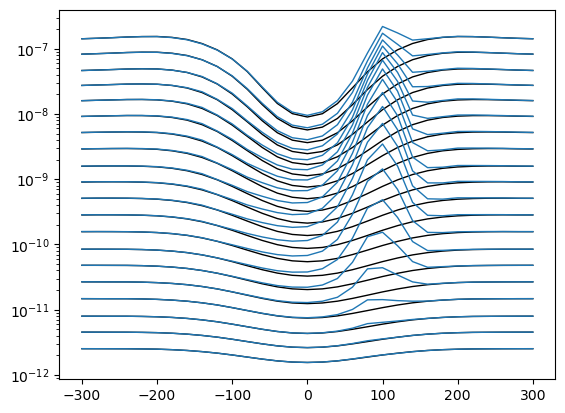

In [125]:
fig, ax = plt.subplots(1, 1)
line = 7
ax.semilogy(rx_x, dpred_values[:,line*len(rx_x):(line+1)*len(rx_x)].T, color="k", label="uniform", lw=1);
ax.semilogy(rx_x, dpred_values_target[:,line*len(rx_x):(line+1)*len(rx_x)].T, color="C0", label="uniform", lw=1);

In [126]:
from simpeg import Data

In [130]:
# data_invert = Data(survey, dobs = discretize.utils.mkvc(dpred_values))
data_invert_target = Data(survey, dobs = discretize.utils.mkvc(dpred_values_target))


In [131]:
relative_error = 0.05
noise_floor = 1e-12

In [133]:

source_list = data_invert.survey.source_list

# for d, dinvert in zip(
#     directories,[ data_invert, data_invert_target]
# ):
d = td_octree_directory_target
dinvert = data_invert_target

with open(f"{d}/dobs.txt", "w") as f:
    f.write(f"IGNORE -9.9999000e+004\n")
    f.write(f"N_TRX {len(source_list)}\n\n")

    for src in dinvert.survey.source_list: 
        f.write(f"TRX_LOOP\n")
        f.write(f"{src.location[0]}\t{src.location[1]}\t{src.location[2]}\t{src.radius}\t0\t0\n\n")

        f.write(f"N_RECV 1\n")
        f.write(f"N_TIME {n_times_invert}\n")
        for i, t in enumerate(rx_times[:n_times_invert]):
            rx = src.receiver_list[0]
            datum = dinvert[src, rx][i]
            std = np.abs(datum) * relative_error + noise_floor
            f.write(
                f"{rx.locations[0, 0]}\t{rx.locations[0, 1]}\t{rx.locations[0, 2]}\t{t} "+
                f"-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t" + # E data 
                f"-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t" + # H data 
                f"-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t{datum}\t{std}\n"
            )
            
        f.write("\n")
            


        

In [185]:
mrec = discretize.TreeMesh.read_model_UBC(ubc_mesh, f"{td_octree_directory}/inv.con")
mrec_target = discretize.TreeMesh.read_model_UBC(ubc_mesh, f"{td_octree_directory_target}/inv_017.con")

In [186]:
rx_locs

array([[-300.        , -280.        ,   30.00038667],
       [-280.        , -280.        ,   30.00095702],
       [-260.        , -280.        ,   30.00222515],
       ...,
       [ 260.        ,  280.        ,   30.00222515],
       [ 280.        ,  280.        ,   30.00095702],
       [ 300.        ,  280.        ,   30.00038667]])

In [187]:
len(rx_y)

15

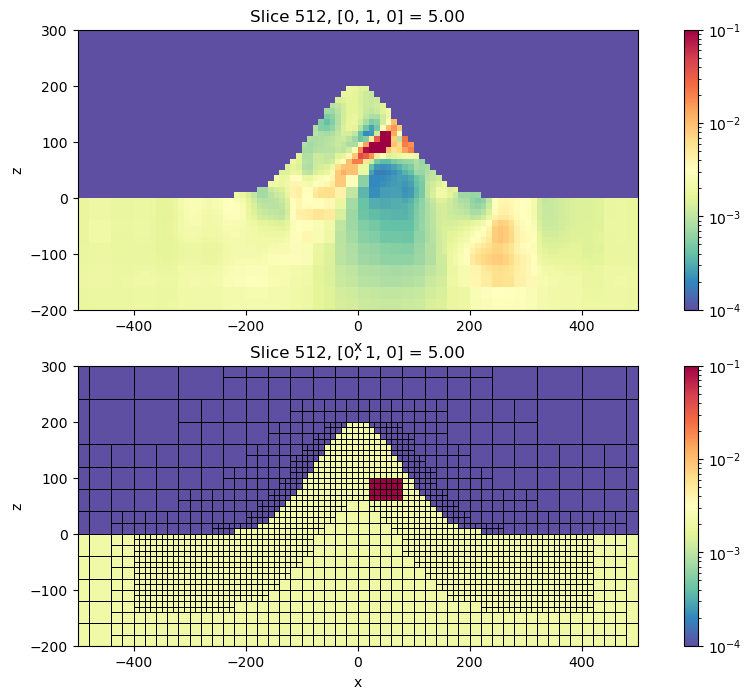

In [188]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

pcolor_opts = {"norm":LogNorm(vmin=1e-4, vmax=1e-1), "cmap":"Spectral_r"}

plt.colorbar(
    ubc_mesh.plot_slice(
        mrec_target, ax=ax[0], pcolor_opts=pcolor_opts, 
        normal="y",
        # grid_opts={"color":"k","lw":0.5}
        # ind=1044
    )[0], ax=ax[0]
)
plt.colorbar(
    ubc_mesh.plot_slice(
        target_model, ax=ax[1], pcolor_opts=pcolor_opts, 
        normal="y",
        grid_opts={"color":"k","lw":0.5}
        # ind=1044
    )[0], ax=ax[1]
)

ind_rx_locs = 7
for a in ax.flatten(): 
    a.set_xlim(500*np.r_[-1, 1])
    a.set_ylim(np.r_[-200, 300])
    # a.plot(rx_locs[ind_rx_locs, 0], rx_locs[ind_rx_locs, 2], "wo", ms=4)
    a.set_aspect(1)

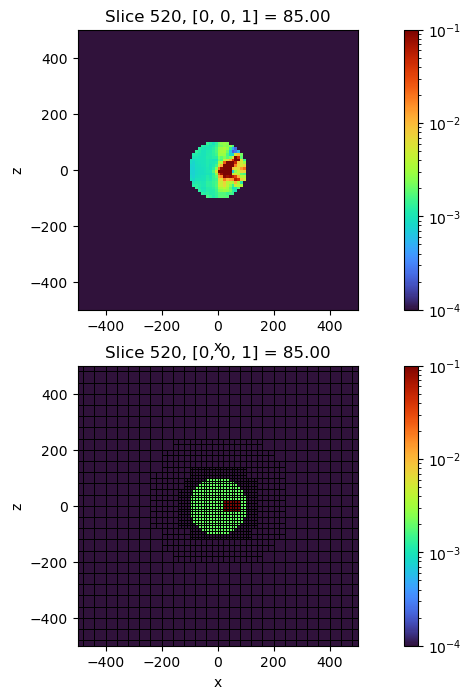

In [190]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

pcolor_opts = {"norm":LogNorm(vmin=1e-4, vmax=1e-1), "cmap":"turbo"}
ind=520
plt.colorbar(
    ubc_mesh.plot_slice(
        mrec_target, ax=ax[0], pcolor_opts=pcolor_opts, 
        normal="Z",
        # grid_opts={"color":"k","lw":0.5}
        ind=ind,
    )[0], ax=ax[0]
)
plt.colorbar(
    ubc_mesh.plot_slice(
        target_model, ax=ax[1], pcolor_opts=pcolor_opts, 
        normal="Z",
        grid_opts={"color":"k","lw":0.5},
        ind=ind,
    )[0], ax=ax[1]
)

ind_rx_locs = 7
for a in ax.flatten(): 
    a.set_xlim(500*np.r_[-1, 1])
    a.set_ylim(500*np.r_[-1, 1])
    # a.plot(rx_locs[ind_rx_locs, 0], rx_locs[ind_rx_locs, 2], "wo", ms=4)
    a.set_aspect(1)

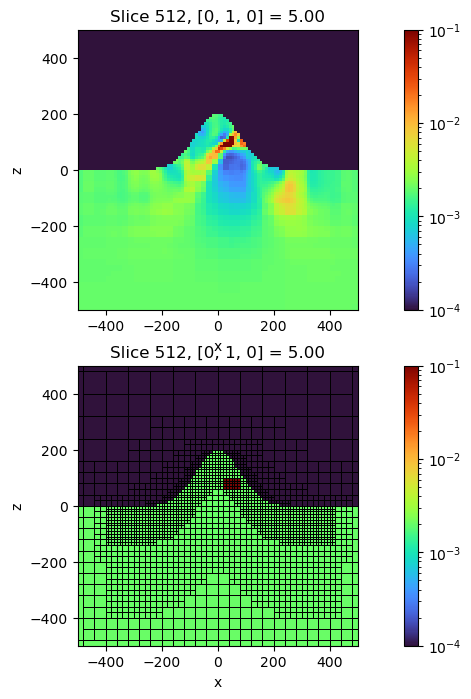

In [192]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

pcolor_opts = {"norm":LogNorm(vmin=1e-4, vmax=1e-1), "cmap":"turbo"}
ind=520
plt.colorbar(
    ubc_mesh.plot_slice(
        mrec_target, ax=ax[0], pcolor_opts=pcolor_opts, 
        normal="Y",
        # grid_opts={"color":"k","lw":0.5}
        # ind=ind,
    )[0], ax=ax[0]
)
plt.colorbar(
    ubc_mesh.plot_slice(
        target_model, ax=ax[1], pcolor_opts=pcolor_opts, 
        normal="Y",
        grid_opts={"color":"k","lw":0.5},
        # ind=ind,
    )[0], ax=ax[1]
)

ind_rx_locs = 7
for a in ax.flatten(): 
    a.set_xlim(500*np.r_[-1, 1])
    a.set_ylim(500*np.r_[-1, 1])
    # a.plot(rx_locs[ind_rx_locs, 0], rx_locs[ind_rx_locs, 2], "wo", ms=4)
    a.set_aspect(1)